# **Question and Answer Chat Bots**

## Loading the Data

We will be working with the Babi Data Set from Facebook Research.

Full Details: https://research.fb.com/downloads/babi/

- Jason Weston, Antoine Bordes, Sumit Chopra, Tomas Mikolov, Alexander M. Rush,
  "Towards AI-Complete Question Answering: A Set of Prerequisite Toy Tasks",
  http://arxiv.org/abs/1502.05698

In [90]:
from google.colab import drive

drive.mount('/content/gdrive')

root_path = '/content/gdrive/My Drive/SoftComProject/'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [91]:
import keras
keras.__version__

'2.4.3'

#Load Data

In [92]:
import pickle
import numpy as np

In [93]:
with open('/content/gdrive/MyDrive/SoftComProject/train_qa.txt','rb') as f:
  train_data = pickle.load(f)

In [94]:
with open('/content/gdrive/MyDrive/SoftComProject/test_qa.txt','rb') as f:
  test_data = pickle.load(f)

## Exploring the Format of the Data

In [95]:
type(train_data)

list

In [96]:
type(test_data)

list

In [97]:
### ration 10 : 1
print("Train data : ",len(train_data))
print("Train data : ",len(test_data))

Train data :  10000
Train data :  1000


In [98]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [99]:
### For story
' '.join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [100]:
### for Q
' '.join(train_data[0][1])

'Is Sandra in the hallway ?'

In [101]:
### for ans
train_data[0][2]

'no'

In [102]:
cnt1 = 0
cnt2 = 0

for i in range(int(len(train_data))):
  #print()
    if (train_data[i][2] == "no"):
      cnt1 = cnt1 + 1
    elif (train_data[i][2] == "yes"):
      cnt2 = cnt2 + 1

print(cnt1," ",cnt2)

4988   5012


-----

## Setting up Vocabulary of All Words

In [103]:
set(train_data[0][0])

{'.',
 'Mary',
 'Sandra',
 'bathroom',
 'bedroom',
 'journeyed',
 'moved',
 'the',
 'to'}

In [104]:
vocab = set()
all_data = test_data + train_data

In [105]:
len(all_data)

11000

In [106]:
#### all distinct elements in present in all the sets
for story, question , answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))
  

In [107]:
###Then we're going to add in the two possible answers which are yes or no so say vocab at a no and vocab and yes.
vocab.add('no')
vocab.add('yes')


In [108]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [109]:
#### use carris pad sequences and zero is a placeholder for that

vocab_len = len(vocab) + 1


In [110]:
#all_data[0]
all_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [111]:
all_story_lens = [len(data[0]) for data in all_data]

In [112]:
#all_story_lens

In [113]:
max_story_len = max(all_story_lens)

In [114]:
max_story_len

156

In [115]:
max_question_len = max([len(data[1]) for data in all_data ])

In [116]:
max_question_len

6

## **Vectorizing the Data**

In [117]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [118]:
# Reserve 0 for pad_sequences
vocab_size = len(vocab) + 1

In [119]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [120]:
# integer encode sequences of words
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [121]:
tokenizer.word_index

{'.': 25,
 '?': 23,
 'apple': 12,
 'back': 20,
 'bathroom': 1,
 'bedroom': 18,
 'daniel': 35,
 'discarded': 26,
 'down': 3,
 'dropped': 28,
 'football': 21,
 'garden': 2,
 'got': 29,
 'grabbed': 10,
 'hallway': 32,
 'in': 13,
 'is': 9,
 'john': 6,
 'journeyed': 14,
 'kitchen': 34,
 'left': 5,
 'mary': 16,
 'milk': 7,
 'moved': 37,
 'no': 17,
 'office': 36,
 'picked': 4,
 'put': 33,
 'sandra': 27,
 'the': 8,
 'there': 24,
 'to': 30,
 'took': 19,
 'travelled': 15,
 'up': 31,
 'went': 22,
 'yes': 11}

In [122]:
train_story_text = []
train_question_text = []
train_answers = []

for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)

In [123]:
#train_story_text

In [124]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [125]:
len(train_story_text)

10000

In [126]:
len(train_story_seq)

10000

In [127]:
train_story_seq[0]

[16, 37, 30, 8, 1, 25, 27, 14, 30, 8, 18, 25]

In [128]:
train_story_text[0]

['Mary',
 'moved',
 'to',
 'the',
 'bathroom',
 '.',
 'Sandra',
 'journeyed',
 'to',
 'the',
 'bedroom',
 '.']

##**Vectorize Stories**
### Functionalize Vectorization

In [129]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len,max_question_len=max_question_len):

    # X = STORIES
    X = []
    # Xq = QUERY/QUESTION
    Xq = []
    # Y = CORRECT ANSWER
    Y = []
    
    
    for story, query, answer in data:
        x = [word_index[word.lower()] for word in story]
    
        xq = [word_index[word.lower()] for word in query]
        
        y = np.zeros(len(word_index) + 1)

        y[word_index[answer]] = 1
        
       
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
  
    return (pad_sequences(X, maxlen=max_story_len),pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [130]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [131]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [132]:
inputs_test

array([[ 0,  0,  0, ...,  8, 18, 25],
       [ 0,  0,  0, ...,  8,  2, 25],
       [ 0,  0,  0, ...,  8,  2, 25],
       ...,
       [ 0,  0,  0, ...,  8, 12, 25],
       [ 0,  0,  0, ...,  8,  2, 25],
       [ 0,  0,  0, ..., 12, 24, 25]], dtype=int32)

In [133]:
queries_test

array([[ 9,  6, 13,  8, 34, 23],
       [ 9,  6, 13,  8, 34, 23],
       [ 9,  6, 13,  8,  2, 23],
       ...,
       [ 9, 16, 13,  8, 18, 23],
       [ 9, 27, 13,  8,  2, 23],
       [ 9, 16, 13,  8,  2, 23]], dtype=int32)

In [134]:
answers_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [135]:
sum(answers_test)

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
       497.,   0.,   0.,   0.,   0.,   0., 503.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.])

In [136]:
tokenizer.word_index['yes']

11

In [137]:
tokenizer.word_index['no']

17

## **Creating the Model**

In [138]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM

### Placeholders for Inputs

In [139]:
#placeholder shape = (max_story_len,batch_size)
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

### Building the Networks
  "End-To-End Memory Networks",
  http://arxiv.org/abs/1503.08895

## Encoders

### Input Encoder m

In [140]:
# Input gets embedded to a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))
input_encoder_m.add(Dropout(0.3))

# This encoder will output:
# (samples, story_maxlen, embedding_dim)

### Input Encoder c

In [141]:
# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))
# output: (samples, story_maxlen, query_maxlen)

### Question Encoder

In [142]:
# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=max_question_len))
question_encoder.add(Dropout(0.3))
# output: (samples, query_maxlen, embedding_dim)

### Encode the Sequences

In [143]:
# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

##### Use dot product to compute the match between first input vector seq and the query

In [144]:
# shape: `(samples, story_maxlen, query_maxlen)`
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

#### Add this match matrix with the second input vector sequence

In [145]:
# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

#### Concatenate

In [146]:
# concatenate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded])

In [147]:
answer

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate_1')>

In [148]:
# Reduce with RNN (LSTM)
#answer = LSTM(1)(answer)
answer = LSTM(32)(answer)
#answer = LSTM(50)(answer) 


In [149]:
# Regularization with Dropout
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)

In [150]:
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

In [151]:
# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [152]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 156)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, None, 64)     2432        input_3[0][0]                    
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 6, 64)        2432        input_4[0][0]                    
____________________________________________________________________________________________

In [153]:
# train
#history = model.fit([inputs_train, queries_train], answers_train,batch_size=100,epochs=50,validation_data=([inputs_test, queries_test], answers_test))
#history = model.fit([inputs_train, queries_train], answers_train,batch_size=100,epochs=100,validation_data=([inputs_test, queries_test], answers_test))
#history = model.fit([inputs_train, queries_train], answers_train,batch_size=70,epochs=100,validation_data=([inputs_test, queries_test], answers_test))
history = model.fit([inputs_train, queries_train], answers_train,batch_size=32,epochs=100,validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/100
313/313 [==============================] - 4s 8ms/step - loss: 1.2665 - accuracy: 0.4777 - val_loss: 0.7014 - val_accuracy: 0.5030
Epoch 2/100
313/313 [==============================] - 2s 7ms/step - loss: 0.7079 - accuracy: 0.5020 - val_loss: 0.6935 - val_accuracy: 0.5030
Epoch 3/100
313/313 [==============================] - 2s 6ms/step - loss: 0.6972 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.5030
Epoch 4/100
313/313 [==============================] - 2s 6ms/step - loss: 0.6958 - accuracy: 0.4901 - val_loss: 0.6932 - val_accuracy: 0.5030
Epoch 5/100
313/313 [==============================] - 2s 7ms/step - loss: 0.6945 - accuracy: 0.5023 - val_loss: 0.6931 - val_accuracy: 0.5030
Epoch 6/100
313/313 [==============================] - 2s 7ms/step - loss: 0.6945 - accuracy: 0.5009 - val_loss: 0.6935 - val_accuracy: 0.5030
Epoch 7/100
313/313 [==============================] - 2s 6ms/step - loss: 0.6945 - accuracy: 0.5020 - val_loss: 0.6936 - val_accuracy: 0.4970

## Evaluating the Model

### Plotting Out Training History

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


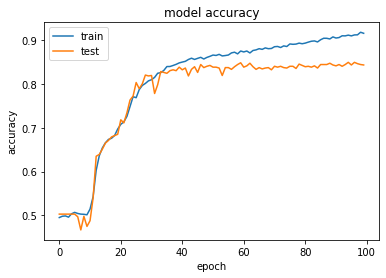

In [154]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [155]:
## mount
from google.colab import drive

drive.mount('/content/gdrive')

root_path = '/content/gdrive/My Drive/SoftComProject/'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [156]:
##Save Model

save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    model.save( root_path + 'QABot.h5') 

In [157]:
#Load Model
load_model = True
if load_model is True:
    model.load_weights(root_path + 'QABot.h5')
    print('Trained Model Loaded')

Trained Model Loaded


In [158]:
pred_results = model.predict(([inputs_test, queries_test]))

In [159]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [160]:
pred_results

array([[1.13774228e-15, 1.06459442e-15, 1.11959481e-15, ...,
        1.17635046e-15, 1.29405469e-15, 1.17962181e-15],
       [1.31822970e-16, 1.13819417e-16, 1.10429975e-16, ...,
        1.15724765e-16, 1.38542456e-16, 1.10478011e-16],
       [4.86164354e-16, 5.66122411e-16, 5.32691821e-16, ...,
        4.90663846e-16, 4.86275633e-16, 5.75011228e-16],
       ...,
       [2.14069131e-17, 2.14557217e-17, 2.14426308e-17, ...,
        2.37699829e-17, 2.85656303e-17, 2.49247022e-17],
       [3.66744726e-16, 4.03369980e-16, 3.45618665e-16, ...,
        3.37481087e-16, 2.70685816e-16, 4.25926600e-16],
       [8.39558676e-17, 8.33648239e-17, 9.48615822e-17, ...,
        1.10270395e-16, 9.55337756e-17, 1.00475889e-16]], dtype=float32)

In [161]:
pred_results.shape ## 1000 test data and 37 vocab + 1

(1000, 38)

In [162]:
pred_results[0] #probability

array([1.1377423e-15, 1.0645944e-15, 1.1195948e-15, 1.1829476e-15,
       1.1870203e-15, 1.1391973e-15, 1.0410444e-15, 1.2453256e-15,
       1.2677336e-15, 1.2666315e-15, 9.9474427e-16, 5.6588103e-04,
       1.0298386e-15, 1.3049655e-15, 1.2079690e-15, 1.3442445e-15,
       1.2663127e-15, 9.9943405e-01, 1.4067585e-15, 1.2606397e-15,
       1.3132152e-15, 1.1032721e-15, 1.2875795e-15, 1.2975248e-15,
       1.1776840e-15, 1.3121386e-15, 9.9866804e-16, 1.2119062e-15,
       1.2386595e-15, 1.2402102e-15, 1.1457477e-15, 1.3013267e-15,
       1.1116834e-15, 1.1507585e-15, 9.7870972e-16, 1.1763505e-15,
       1.2940547e-15, 1.1796218e-15], dtype=float32)

In [163]:
test_data[0]

(['Mary',
  'got',
  'the',
  'milk',
  'there',
  '.',
  'John',
  'moved',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'John', 'in', 'the', 'kitchen', '?'],
 'no')

In [164]:
val_max = np.argmax(pred_results[0])

In [165]:
for key,val in tokenizer.word_index.items():
  if val == val_max:
    k = key

In [166]:
k 

'no'

In [167]:
pred_results[0][val_max]

0.99943405

In [168]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [169]:
# Note the whitespace of the periods
my_story = "John left the kitchen . Sandra dropped the football in the garden ."
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [170]:
my_question = "Is the football in the garden ?"

In [171]:
my_question.split()

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [172]:
mydata = [(my_story.split(),my_question.split(),'yes')]

In [173]:
mydata

[(['John',
   'left',
   'the',
   'kitchen',
   '.',
   'Sandra',
   'dropped',
   'the',
   'football',
   'in',
   'the',
   'garden',
   '.'],
  ['Is', 'the', 'football', 'in', 'the', 'garden', '?'],
  'yes')]

In [174]:
my_story,my_ques,my_ans = vectorize_stories(mydata)

In [175]:
my_story

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,
         5,  8, 34, 25, 27, 28,  8, 21, 13,  8,  2, 25]], dtype=int32)

In [176]:
pred_results = model.predict(([ my_story, my_ques]))

In [177]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  0.7153269
